In [ ]:
# Import necessary libraries
import time
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [ ]:
RANDOM_STATE: int = 42

# Task 1

The tutorial classifies between only four categories of the 20newsgroups data set. Change your script so that it addresses all 20 categories.

In [ ]:
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6

def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        shuffle=True,
        random_state=RANDOM_STATE,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        shuffle=True,
        random_state=RANDOM_STATE,
        remove=remove,
    )

    target_names = data_train.target_names

    X_train, X_test = data_train.data, data_test.data
    y_train, y_test = data_train.target, data_test.target

    if verbose:
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = load_dataset(verbose=True)

11314 documents - 22.05MB (training set)
7532 documents - 13.80MB (test set)
20 categories


# Task 2

Compare three classifiers in sklearn on this multi-class classification task, including at least Naïve Bayes.

Notes:
* Multinomial Naive Bayes - designed for discrete data, such as word counts or term frequencies in text classification.
* Logistic Regression - models the probability that a given input belongs to a particular class using a logistic function.
* Liner Support Vector Classifier (LinearSVC) - finds the hyperplane that best separates classes by maximizing margin between them.

In [ ]:
# max_iter=100 for LogisticRegression is a default value (we could try=1000)
# max_iter=1000 for LinearSVC is a default value (we could try=10000)

classifiers = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, verbose=1, n_jobs=-1),
    'LinearSVC': LinearSVC(max_iter=10000, random_state=RANDOM_STATE, verbose=1)
}

# Task 3

Compare three types of features for your classifiers: counts, tf, and tf-idf. Keep the best combination of a classifier and a feature type for the next task.

In [ ]:
feature_methods = {
    'Count': CountVectorizer(),
    'TF': CountVectorizer(binary=False),
    'TF-IDF': TfidfVectorizer()
}

In [ ]:
results = []

# Iterate over feature extraction methods
for feature_name, vectorizer in feature_methods.items():
    print(f"\n[INFO] Using feature extraction method: {feature_name}")
    start_time = time.time()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    print(f"[INFO] Feature extraction done in {time.time() - start_time:.2f} seconds")


    # Iterate over classifiers
    for clf_name, clf in classifiers.items():
        print(f"\n[INFO] Training classifier: {clf_name}")
        start_time = time.time()
        clf.fit(X_train_vec, y_train)
        print(f"[INFO] Classifier {clf_name} trained in {time.time() - start_time:.2f} seconds")

        start_time = time.time()
        y_pred = clf.predict(X_test_vec)
        print(f"[INFO] Predictions made in {time.time() - start_time:.2f} seconds")

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='weighted', zero_division=0
        )

        results.append({
            'Classifier': clf_name,
            'Feature': feature_name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

print("\n[INFO] All classifiers and feature extractions completed.")

results_df = pd.DataFrame(results)
print(results_df)

# Task 3 results

I got this results by running native settings for LinearSVC and LogisticRegression. However, I was running into warning that I should try to increase the `max_iter` parameters, since algorithms have not converged.

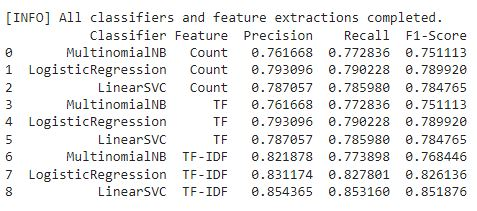

After increasing the default `max_iter` parameters by a factor of 10, both algorithms have successfully converged. Below are the results obtained from the predictions.

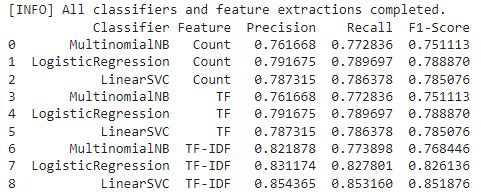

## Best classifier-feature combination

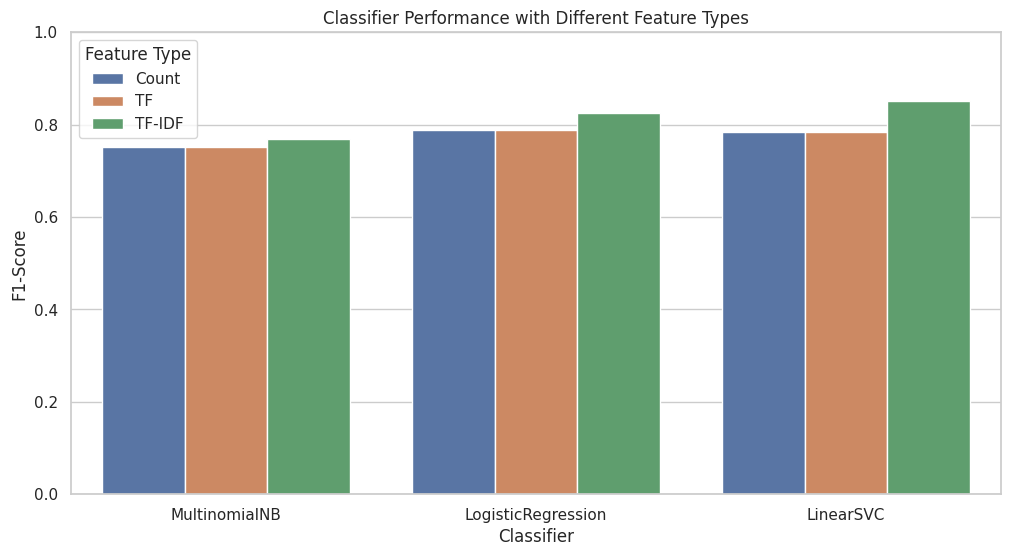

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x='Classifier', y='F1-Score', hue='Feature', data=results_df)
plt.title('Classifier Performance with Different Feature Types')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.legend(title='Feature Type')
plt.show()

In [ ]:
best_result = results_df.loc[results_df['F1-Score'].idxmax()]
best_classifier = best_result['Classifier']
best_feature = best_result['Feature']

print(f"Best Classifier: {best_classifier}")
print(f"Best Feature Type: {best_feature}")

Best Classifier: LinearSVC
Best Feature Type: TF-IDF


# Task 4

Look up the documentation of the CountVectorizer function and experiment with different values for the following parameters for your best classifier-feature combination. For each of these parameters compare different values and store the results.
* Lowercasing (true or false)
* stop_words (with or without)
* analyzer (in combination with ngram_range), try out a few values
* max_features, try out a few values

In [ ]:
param_grid = {
    'vectorizer__lowercase': [True, False],
    'vectorizer__stop_words': [None, 'english'],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__max_features': [None, 5000, 10000]
}

pipeline = Pipeline([
    ('vectorizer', feature_methods[best_feature]),
    ('classifier', classifiers[best_classifier])
])

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=2,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=10
)

In [ ]:
grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)

y_pred_best = grid_search.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_best, average='weighted', zero_division=0
)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[LibLinear]Best Parameters:
{'vectorizer__lowercase': True, 'vectorizer__max_features': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}
Precision: 0.8586
Recall: 0.8574
F1-Score: 0.8562


In [ ]:
param_grid = {
    'vectorizer__lowercase': [True, False],
    'vectorizer__stop_words': [None, 'english'],
    'vectorizer__ngram_range': [(1,1), (1,2), (2, 2)],
    'vectorizer__max_features': [None, 5000, 10000]
}

pipeline = Pipeline([
    ('vectorizer', feature_methods[best_feature]),
    ('classifier', classifiers[best_classifier])
])

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=10
)


In [ ]:
grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)

y_pred_best = grid_search.predict(X_test)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_best, average='weighted', zero_division=0
)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits

[LibLinear]Best Parameters:

{'vectorizer__lowercase': True, 'vectorizer__max_features': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}

- Precision: 0.8586
- Recall: 0.8574
- F1-Score: 0.8562